# `photutils` Aperture Photometry

If you've followed the lecture materials, there are two major ways to do aperture photometry:

1. Find stars using `DAOStarFinder`. Generate sky map by SExtractor. Subtract it from the image. Do the usual aperture sum to the star.
2. Find stars using `DAOStarFinder`. Get aperture sum from aperture, get sky from annulus. Subtract sky from the aperture sum.

I will demonstrate both here using the M13 image we were using.

## 0. Common code

For brevity, I want to import all necessary packages first, load the image, and do `DAOStarFinder` and make apertures first, because these will be used for both methods.

The image has already been converted to "electrons per second" unit, so the process of error estimation is somewhat tricky. So, let me just multiply 10^4 and integerize the pixels to mimic the original ADU image. The total read noise is about 5 electrons and gain is 7 e/ADU.


In [92]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clip, sigma_clipped_stats
from photutils import DAOStarFinder, Background2D, SigmaClip, SExtractorBackground
from photutils import CircularAperture as CircAp
from photutils import CircularAnnulus as CircAn
from photutils import aperture_photometry as APPHOT

#%%
hdu = fits.open('HST_Tutorial/M13.fits')
img = hdu[0].data[900:1200, 900:1200]
# if image value < 10^(-6), replace the pixel as 10^(-6)
img[img < 1.e-6] = 1.e-6

# multiply 10**4 and integrize to mimic ADU
img *= 1.e4
img = img.astype(int)
ronoise = 5  # electrons
gain = 7     # e/ADU

FWHM   = 2.5
sky_th = 500   # sky_th * sky_sigma will be used for detection lower limit
sky_a, sky_m, sky_s  = sigma_clipped_stats(img) # 3-sigma, 5 iters
thresh = sky_th * sky_s

find   = DAOStarFinder(fwhm=FWHM, threshold=thresh,
                       sharplo=0.2, sharphi=1.0,  # default values 
                       roundlo=-1.0, roundhi=1.0, # default values
                       sigma_radius=1.5,          # default values
                       ratio=1.0,                 # 1.0: circular gaussian
                       exclude_border=True)       # To exclude sources near edges
found = find(img)

N_star = len(found)
# save XY coordinates and aperture:
coord = (found['xcentroid'], found['ycentroid']) 
apert = CircAp(positions=coord, r=max(3, FWHM))
annul = CircAn(positions=coord, r_in=4*FWHM, r_out=6*FWHM)

* **TIP**: It's best to use aperture of `max(3, 1.0 * FWHM)`.

We must also transform the aperture sum (in ADU) to instrument magnitude. To do so, let me define a function, as well as `sky_fit`:

In [89]:
def mag_inst(flux, ferr):
    ''' Returns magnitude from flux.
    '''
    m_inst = -2.5 * np.log10(flux)
    merr   = 2.5/np.log(10) * ferr / flux
    return m_inst, merr

def sky_fit(all_sky, method='mode', sky_nsigma=3, sky_iter=5, \
            mode_option='sex', med_factor=2.5, mean_factor=1.5):
    '''
    Estimate sky from given sky values.

    Parameters
    ----------
    all_sky : ~numpy.ndarray
        The sky values as numpy ndarray format. It MUST be 1-d for proper use.
    method : {"mean", "median", "mode"}, optional
        The method to estimate sky value. You can give options to "mode"
        case; see mode_option.
        "mode" is analogous to Mode Estimator Background of photutils.
    sky_nsigma : float, optinal
        The input parameter for sky sigma clipping.
    sky_iter : float, optinal
        The input parameter for sky sigma clipping.
    mode_option : {"sex", "IRAF", "MMM"}, optional.
        sex  == (med_factor, mean_factor) = (2.5, 1.5)
        IRAF == (med_factor, mean_factor) = (3, 2)
        MMM  == (med_factor, mean_factor) = (3, 2)

    Returns
    -------
    sky : float
        The estimated sky value within the all_sky data, after sigma clipping.
    std : float
        The sample standard deviation of sky value within the all_sky data,
        after sigma clipping.
    nsky : int
        The number of pixels which were used for sky estimation after the
        sigma clipping.
    nrej : int
        The number of pixels which are rejected after sigma clipping.
    -------

    '''
    sky = all_sky.copy()
    if method == 'mean':
        return np.mean(sky), np.std(sky, ddof=1)

    elif method == 'median':
        return np.median(sky), np.std(sky, ddof=1)

    elif method == 'mode':
        sky_clip   = sigma_clip(sky, sigma=sky_nsigma, iters=sky_iter)
        sky_clipped= sky[np.invert(sky_clip.mask)]
        nsky       = np.count_nonzero(sky_clipped)
        mean       = np.mean(sky_clipped)
        med        = np.median(sky_clipped)
        std        = np.std(sky_clipped, ddof=1)
        nrej       = len(all_sky) - len(sky_clipped)

        if nrej < 0:
            raise ValueError('nrej < 0: check the code')

        if nrej > nsky: # rejected > survived
            raise Warning('More than half of the pixels rejected.')

        if mode_option == 'IRAF':
            if (mean < med):
                sky = mean
            else:
                sky = 3 * med - 2 * mean

        elif mode_option == 'MMM':
            sky = 3 * med - 2 * mean

        elif mode_option == 'sex':
            if (mean - med) / std > 0.3:
                sky = med
            else:
                sky = (2.5 * med) - (1.5 * mean)
        else:
            raise ValueError('mode_option not understood')

        return sky, std, nsky, nrej


## 1. Using SExtractor


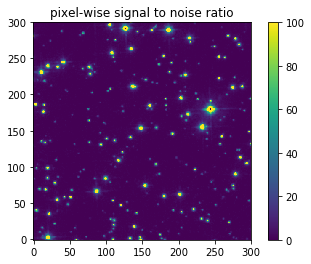

 id      xcenter            ycenter        aperture_sum aperture_sum_err
           pix                pix                                       
--- ------------------ ------------------ ------------- ----------------
  1 133.22403833586998  2.083764297528783  39422.682536    94.6782836987
  2  20.29308459255889  3.379328460375729 350919.980755    236.188874518
  3 139.10054870433788 18.133488862654865 55865.4832182    106.480792646
  4 21.738099399931475   35.7746203491017 78191.6797728    128.326530097
  5  32.67023094901688  55.29096540534828 87838.1883383    132.710939968
  6  179.9388019681347 60.297706747190695 54721.8098395    105.033413503
  7 201.64762230868146  62.64675355972699 144267.244622    153.779404664
  8  87.36978548680972  66.59588726615048 116346.552834    143.032418684
  9  154.0115559009857  74.94082376649413 126753.034967    146.618926077
 10  99.52406103805424  84.88554016621657 117199.641601    141.647778147
...                ...                ...          

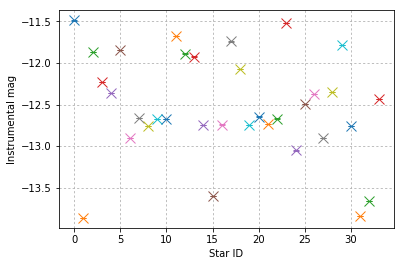

In [90]:
box  = np.array((30, 30)).astype(int)         # 30 by 30 box, so 10 by 10 mesh.
filt = np.array((2*FWHM, 2*FWHM)).astype(int)
sigma_clip = SigmaClip(sigma=3., iters=10)

# The SExtractor method
bkg_sex = Background2D(img, 
                       box_size=box, 
                       filter_size=filt,
                       sigma_clip=sigma_clip, 
                       bkg_estimator=SExtractorBackground())

# sky_subtracted
img_ss = img - bkg_sex.background

# pixel-wise errors
img_em = np.sqrt(img * gain + ronoise**2 
                 + (bkg_sex.background_rms * gain)**2) / gain
# This is used to make errormap in ADU scale. 

plt.imshow(img_ss/img_em, vmin=0, vmax=100, origin='lower')
plt.title('pixel-wise signal to noise ratio')
plt.colorbar()
plt.show()

# do photometry
phot_sex = APPHOT(img_ss, apert, error=img_em)
phot_sex.pprint(max_width=200)
mag_sex, merr_sex = mag_inst(phot_sex['aperture_sum'], phot_sex['aperture_sum_err'])
for i in range(0, N_star):
    plt.errorbar(i, mag_sex[i], yerr=merr_sex[i], marker='x', ms=10, capsize=3)
plt.xlabel('Star ID')
plt.ylabel('Instrumental mag')
plt.grid(ls=':')
plt.show()

## 2. Using Circular Annulus


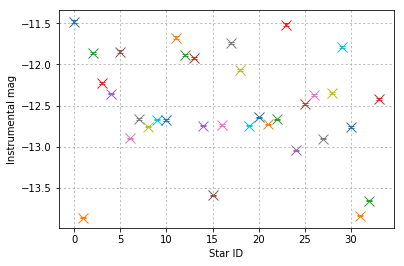

In [93]:
mag_ann  = np.zeros(N_star)
merr_ann = np.zeros(N_star)


# aperture sum
apert_sum = APPHOT(img, apert, method='exact')['aperture_sum']
ap_area   = apert.area()

for i in range(0, N_star):
    # sky estimation
    mask_annul = (annul.to_mask(method='center'))[i]
    sky_apply  = mask_annul.apply(img)
    sky_non0   = np.nonzero(sky_apply)
    sky_pixel  = sky_apply[sky_non0]
    msky, sky_std, nsky, nrej = sky_fit(sky_pixel, method='mode', mode_option='sex')
       
    flux_star = apert_sum[i] - msky * ap_area  # total - sky
    flux_err  = np.sqrt(apert_sum[i] * gain    # Poissonian (star + sky)
                        + ap_area * ronoise**2 # Gaussian
                        + (ap_area * (gain * sky_std))**2 / nsky ) 
    mag_ann[i], merr_ann[i] = mag_inst(flux_star, flux_err)
    plt.errorbar(i, mag_ann[i], yerr=merr_ann[i], marker='x', ms=10, capsize=3)
plt.xlabel('Star ID')
plt.ylabel('Instrumental mag')
plt.grid(ls=':')
plt.show()


## 3. Comparison (SExtractor VS Annulus)



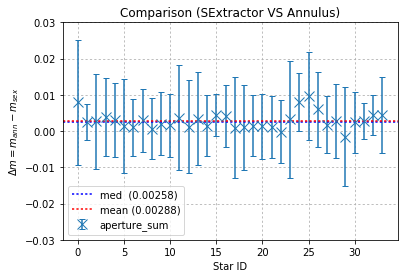

In [97]:
mag_diff  = mag_ann - mag_sex
merr_diff = np.sqrt(merr_ann**2 + merr_sex**2)
med, mean = np.median(mag_diff), np.mean(mag_diff)

plt.errorbar(np.arange(N_star), mag_diff, yerr=merr_diff, marker='x', ms=10,capsize=3, ls='')
plt.xlabel('Star ID')
plt.ylabel('$\Delta m = m_{ann}-m_{sex}$')
plt.title('Comparison (SExtractor VS Annulus)')
plt.grid(ls=':')
plt.ylim(-0.03, 0.03)

plt.axhline(med , color='b', ls=':', label='med  ({:.5f})'.format(med))
plt.axhline(mean, color='r', ls=':', label='mean ({:.5f})'.format(mean))
plt.legend()
plt.show()



From the graph, you can see that both method gives similar result, with median of ~ 0.003 magnitude (0.3%) difference, that is, annulus method regards the target fainter (higher magnitude).

* **Question**: Check whether this holds true for even fainter stars.